In [ ]:
from google.colab import drive
drive.mount('/content/drive/')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive/


*Importing all necessary dependencies*

In [ ]:
import tensorflow as tf
from tensorflow.keras.applications import VGG16
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Dense
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.models import load_model
from sklearn.metrics import classification_report
from sklearn.metrics import confusion_matrix
from sklearn.metrics import accuracy_score
%matplotlib inline
import matplotlib.pyplot as plt
import numpy as np
import cv2
import h5py

*Importing VGG16 keras model as base model for fine tuning -*

*    *by excluding the top layer,*
     
*    *and setting the input_tensor shape as (224,224,3)*








In [ ]:
baseModel = VGG16(weights="imagenet", include_top=False, input_tensor=Input(shape=(224, 224, 3)))

58892288/58889256 [==============================] - 1s 0us/step


In [ ]:
baseModel.summary()

Model: "vgg16"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 224, 224, 3)]     0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0     

In [ ]:
train_datagen = ImageDataGenerator(rescale = 1./255,
                                   shear_range = 0.2,
                                   zoom_range = 0.2,
                                   horizontal_flip = True)

validation_datagen = ImageDataGenerator(rescale = 1./255)

test_datagen = ImageDataGenerator(rescale = 1./255)

training_set = train_datagen.flow_from_directory('/content/drive/My Drive/COVID_19_PROJECT/Face Mask Dataset/Train',
                                                 target_size = (224, 224),
                                                 batch_size = 32,
                                                 class_mode = 'binary')

validation_set = validation_datagen.flow_from_directory('/content/drive/My Drive/COVID_19_PROJECT/Face Mask Dataset/Validation',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary')

test_set = test_datagen.flow_from_directory('/content/drive/My Drive/COVID_19_PROJECT/Face Mask Dataset/Test',
                                            target_size = (224, 224),
                                            batch_size = 32,
                                            class_mode = 'binary',
                                            shuffle = False)

Found 10005 images belonging to 2 classes.
Found 800 images belonging to 2 classes.
Found 992 images belonging to 2 classes.


*Showing the class indices of both the classes*

In [ ]:
test_set.class_indices

{'WithMask': 0, 'WithoutMask': 1}

Defining a function to plot the history of training process 

In [ ]:
def plot_training(H, N, path):
    # construct a plot that plots and saves the training history
    plt.style.use("ggplot")
    plt.figure()
    plt.plot(np.arange(0, N), H.history["loss"], label="train_loss")
    plt.plot(np.arange(0, N), H.history["val_loss"], label="val_loss")
    plt.plot(np.arange(0, N), H.history["accuracy"], label="train_acc")
    plt.plot(np.arange(0, N), H.history["val_accuracy"], label="val_acc")
    plt.title("Training Loss and Accuracy")
    plt.xlabel("Epoch #")
    plt.ylabel("Loss/Accuracy")
    plt.legend(loc="upper right")
    plt.savefig(path)

*Fine tuning the model*

In [ ]:
# constructing the head of the model that will be placed on top of the base model

headModel = baseModel.output
headModel = Flatten(name="flatten")(headModel)
headModel = Dense(1024, activation="relu")(headModel)
headModel = Dropout(0.5)(headModel)
headModel = Dense(1, activation="sigmoid")(headModel)

# place the head FC model on top of the base model (this will become the actual model we will train)

model = Model(inputs=baseModel.input, outputs=headModel)

# freezing the layers of the base model
for layer in baseModel.layers:
    layer.trainable = False

opt = SGD(lr=1e-4, momentum=0.9)
model.compile(loss="binary_crossentropy", optimizer=opt, metrics=["accuracy"])

# train the head of the network for a few epochs (all other layers are frozen) -- this will allow the new FC layers to warmup that is to start to become 
# initialized with actual "learned" values versus pure random
print("[INFO] training head...")
H = model.fit(x=training_set, validation_data=validation_set, epochs=10, steps_per_epoch= 10000//32, validation_steps= 800//32)

for i, layer in enumerate(baseModel.layers):
   print(i, layer.name)

# we will now freeze the first 15 layers of our final model unfreeze the rest:
for layer in model.layers[:15]:
   layer.trainable = False
for layer in model.layers[15:]:
   layer.trainable = True

# we need to recompile the model for these modifications to take effect we use SGD with a low learning rate
model.compile(optimizer=SGD(lr=0.0001, momentum=0.9), loss='binary_crossentropy', metrics=["accuracy"])

# we train our model again, this time fine-tuning 4 layers of the base model alongside the top Dense layers
T = model.fit(x=training_set, validation_data=validation_set, epochs=25, steps_per_epoch= 10000//32, validation_steps= 800//32)

[INFO] training head...
Epoch 1/10
312/312 [==============================] - 3641s 12s/step - loss: 0.2872 - accuracy: 0.8968 - val_loss: 0.1152 - val_accuracy: 0.9812
Epoch 2/10
312/312 [==============================] - 142s 456ms/step - loss: 0.1225 - accuracy: 0.9720 - val_loss: 0.0753 - val_accuracy: 0.9875
Epoch 3/10
312/312 [==============================] - 138s 442ms/step - loss: 0.0894 - accuracy: 0.9774 - val_loss: 0.0632 - val_accuracy: 0.9837
Epoch 4/10
312/312 [==============================] - 138s 442ms/step - loss: 0.0725 - accuracy: 0.9827 - val_loss: 0.0540 - val_accuracy: 0.9850
Epoch 5/10
312/312 [==============================] - 136s 436ms/step - loss: 0.0632 - accuracy: 0.9830 - val_loss: 0.0444 - val_accuracy: 0.9925
Epoch 6/10
312/312 [==============================] - 137s 440ms/step - loss: 0.0598 - accuracy: 0.9848 - val_loss: 0.0443 - val_accuracy: 0.9875
Epoch 7/10
312/312 [==============================] - 135s 434ms/step - loss: 0.0545 - accuracy: 0.98

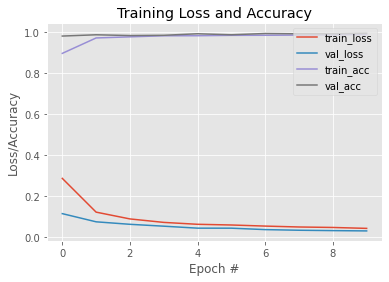

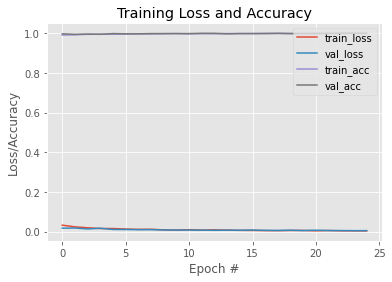

In [ ]:
plot_training(H, 10, '/content/drive/My Drive/COVID_19_PROJECT/WARMUP_H5.png')
plot_training(T, 25, '/content/drive/My Drive/COVID_19_PROJECT/FULL_TRAIN_H5.png')

In [ ]:
# Saving only the weights
model.save_weights('/content/drive/My Drive/COVID_19_PROJECT/weights.h5')

In [ ]:
# Saving the model configuration
json_config = model.to_json()
with open('/content/drive/My Drive/COVID_19_PROJECT/model_config.json', 'w') as json_file:
  json_file.write(json_config)

In [ ]:
# Evaluating the model on the test set
test_loss, test_acc = model.evaluate_generator(test_set, steps=31)

Instructions for updating:
Please use Model.evaluate, which supports generators.


In [ ]:
print(test_acc)
print(test_loss)

0.9979838728904724
0.005673161707818508


In [ ]:
preds = model.predict(x=test_set, steps = 31, workers = 0)
preds = tf.greater(preds, .5)

*Evaluating the model with different metrices*

In [ ]:
print(classification_report(test_set.classes[test_set.index_array], preds, target_names=test_set.class_indices.keys()))
print(confusion_matrix(test_set.classes[test_set.index_array], preds))
print(accuracy_score(test_set.classes[test_set.index_array], preds))

              precision    recall  f1-score   support

    WithMask       1.00      1.00      1.00       483
 WithoutMask       1.00      1.00      1.00       509

    accuracy                           1.00       992
   macro avg       1.00      1.00      1.00       992
weighted avg       1.00      1.00      1.00       992

[[483   0]
 [  2 507]]
0.9979838709677419


In [ ]:
def make_pred(model, path):
  inp = cv2.imread(path)
  plt.imshow(inp)
  inp = cv2.cvtColor(inp, cv2.COLOR_BGR2RGB)
  inp = cv2.resize(inp, (224,224))
  pred = model.predict(np.expand_dims(inp, axis=0), workers = 0)
  if pred>=0.5:
    print("WITHOUT MASK; ACCURACY {}%".format(pred*100))
  else:
    pred = 1-pred
    print("MASK; ACCURACY {}%".format(pred*100))

MASK; ACCURACY [[100.]]%


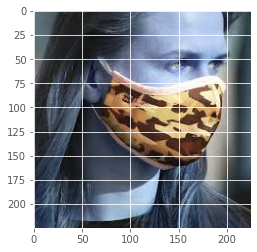

In [ ]:
make_pred(model, '/content/drive/My Drive/COVID_19_PROJECT/images (1).jpg')

MASK; ACCURACY [[100.]]%


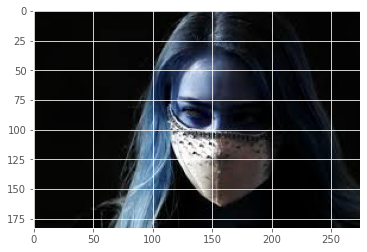

In [ ]:
make_pred(model_loaded, '/content/drive/My Drive/COVID_19_PROJECT/images (2).jpg')

MASK; ACCURACY [[100.]]%


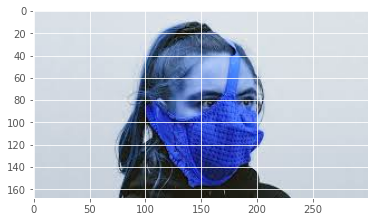

In [ ]:
make_pred(model_loaded, '/content/drive/My Drive/COVID_19_PROJECT/images (3).jpg')

WITHOUT MASK; ACCURACY [[100.]]%


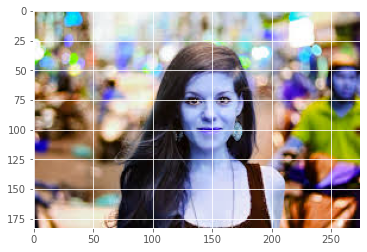

In [ ]:
make_pred(model_loaded, '/content/drive/My Drive/COVID_19_PROJECT/download (2).jpg')

WITHOUT MASK; ACCURACY [[100.]]%


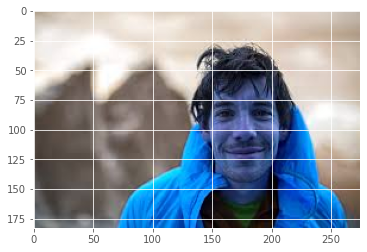

In [ ]:
make_pred(model_loaded, '/content/drive/My Drive/COVID_19_PROJECT/download (5).jpg')